# Assignment-2
## Done By: Abhinav Gupta, 20171059

Image Mosaicing and Stereo Correspondences. We look at the concepts of homography estimation and stereo calibration. 

### Image Mosaicing
Here's what we're going to do:
1. We use ORB (because SIFT is too mainstream) to find the matches between two partially overlapping images. 
2. Estimate the homography matrix between the two images. 
3. Transform one image into other's frame
4. Stitch the images and produce a single mosiac/panorama.

- First, let's import all the libraries we need.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from PIL import Image
import sys
import os

- Let's read the images. 

In [2]:
img1 = cv2.imread('./images/image_mosaicing/img1_1.jpg')
img2 = cv2.imread('./images/image_mosaicing/img1_2.jpg')

- Let's convert these to grayscale

In [3]:
img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

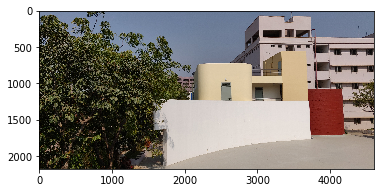

In [4]:
plt.imshow(img1g)

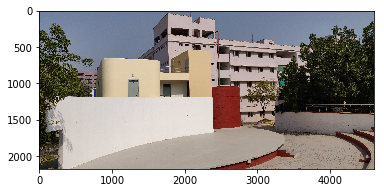

In [5]:
plt.imshow(img2g)

- Let's now compute the ORB keypoints and descriptors to find matches between the two partially overlapping images. 
- This function takes as input the two stereo images and returns list of sift keypoints and their discriptors for each image.

In [6]:
# constant
MIN_MATCH_COUNT = 40

def ORB_features(img_list):
    orb = cv2.ORB_create()

    kp_list = []
    des_list = []
    
    for im in img_list:
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = orb.detectAndCompute(gray,None)
        kp_list.append(kp)
        des_list.append(des)
    
    return kp_list, des_list

- This function gets the interesting features and matches them in both the images and returns them.
- We call `ORB_features` to compute the features and use `BFMatcher` to find the matches. The BFMatcher() matches the features which are more similar. When we set parameter k=2, we are asking the knnMatcher to give out 2 best matches for each descriptor. 
- Now, the obtained descriptors in one image are to be recognized in the image too. 
- kp1 and kp2 are keypoints, des1 and des2 are the descriptors of the respective images.

In [7]:
def feature_matching(img_list):
    
    # create BFMatcher object and compute the ORB features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    kp_list, des_list = ORB_features(img_list)

    # Match descriptors and sort them in the order of their distance.
    matches = bf.match(des_list[0],des_list[1])
    matches = sorted(matches, key = lambda x:x.distance)[:40]
            
    draw_params = dict(matchesMask=None, singlePointColor=None, matchColor=(0, 255, 0), flags=2)
    
    img3 = cv2.drawMatches(img_list[0], kp_list[0], img_list[1], kp_list[1], matches, None, **draw_params)
    plt.imshow(img3)  
    
    return matches,kp_list,des_list

- ‘matches’ is a list of list, where each sub-list consists of ‘k’ objects. 

#### Estimating Homography

- We use the same functions from assignment-1 to build the homography matrix. 
- Homography is a 3x3 matrix as the camera center is assumed to be same for each image
- Our objective is the minimize the distance predicted (after transformation using homography) and the real image coordinates. Hence we have a formulation similar to DLT. 
- We take the least eigen value vector as the homography in each iteration.
- Iteration with least error is the most accurate homography matrix

In [8]:
def find_homography(correspondences):
    aList = []
    for corr in correspondences:
        
        x1 = corr[0]
        x2 = corr[1]
        a2 = [0, 0, 0, -x1[0], -x1[1], -1, x2[1] *x1[0] , x2[1]*x1[1] , x2[1] ]
        a1 = [ -x1[0], -x1[1], -1,  0, 0, 0,  x2[0] * x1[0], x2[0] * x1[1], x2[0] ]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.array(aList)
    u, d, v = np.linalg.svd(matrixA)
    h = np.reshape(v[8], (3, 3))
    h = h/h[2,2]
    return h

In [9]:
def geometricDistance(src,dst, h):
    p1 = np.array([src[0],src[1], 1]).T
    estimatep2 = np.dot(h, p1)
    estimatep2 = estimatep2/estimatep2[2]

    p2 = np.matrix([ dst[0], dst[1], 1]).T
    error = p2 - estimatep2
    return np.linalg.norm(error)

#### RANSAC Loop. 

In [10]:
def ransac(src_pts,dst_pts, thresh, dist=5):
    maxInliers = []
    finalH = None
    for i in range(500):
        r4 =  np.random.randint(0,len(src_pts),4)
        randomFour = []
        for x in r4:
            randomFour.append((src_pts[x,0,:], dst_pts[x,0,:] ))
            
        h = find_homogrpahy(randomFour)
        
        inliers = []

        for i in range(len(src_pts)):
            d = geometricDistance( src_pts[i,0,:], dst_pts[i,0,:] , h)
            if d < dist:
                inliers.append(cr)
        
        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        
        if len(maxInliers) > len(src_pts)*thresh:
            break
        
    return finalH

In [11]:
def calculate_homography(matches,kp_list):    
    if len(matches) < MIN_MATCH_COUNT:
        return None
    best_matches = matches[0:MIN_MATCH_COUNT]
    src_pts = np.float32([ kp_list[0][m.queryIdx].pt for m in best_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_list[1][m.trainIdx].pt for m in best_matches ]).reshape(-1,1,2)
    
    M = ransac(src_pts, dst_pts,0.1,dist=5.0)
#     M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    return M

In [12]:
def get_transformation(img_list):   

    # Feature matching    
    matches,kp_list,des_list =  feature_matching(img_list)

    # Homography
    M = calculate_homography(matches,kp_list)

    h,w,c = img_list[0].shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)    
    img2 = cv2.polylines(img_list[1].copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)

    h,w,c = img_list[1].shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,np.linalg.inv(M))    
    img1 = cv2.polylines(img_list[0].copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)  

    return M

In [13]:
def stitching(img_list,M):
    dst = cv2.warpPerspective(img_list[1],np.linalg.inv(M),(img_list[0].shape[1]+img_list[1].shape[1],img_list[0].shape[0]))
    dst[0:img_list[0].shape[0],0:img_list[0].shape[1],:] = img_list[0]
    return dst

In [14]:
# Remove black region from width
def remove_black(final_img):
    r = np.where(np.sum(final_img,(0,2)) == 0)[0][0]
    final_img = final_img[:,0:r,:]
    return final_img

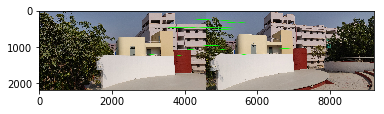

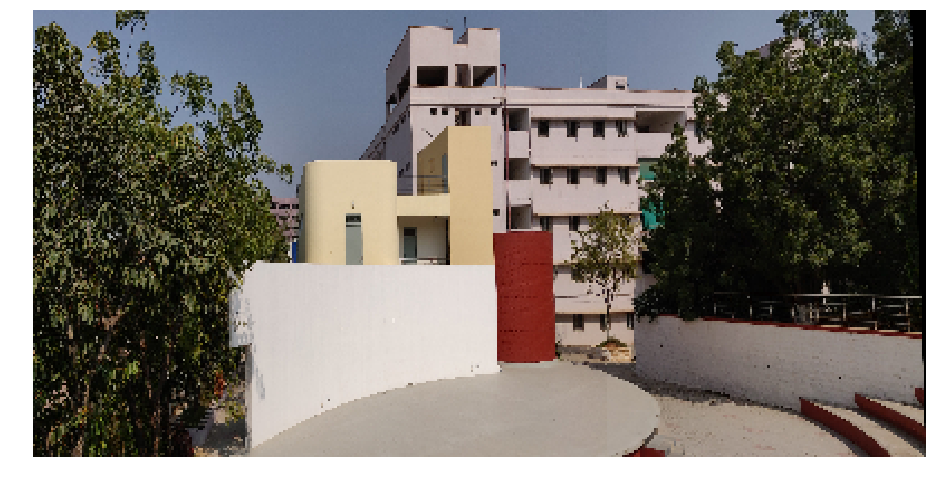

In [17]:
# Load images
img_list = []
img_list.append(img1g)
img_list.append(img2g)

M = get_transformation(img_list) 
final_img = stitching(img_list,M)
final_img = remove_black(final_img)

cv2.imwrite('final_img_amphi.png', final_img)

final_img = cv2.resize(final_img,(400,200))
fig = plt.figure(figsize=(16,16))
plt.imshow(final_img)
plt.axis('off')
plt.show()

In [19]:
# Load images
lol1 = cv2.imread('./images/image_mosaicing/img3_1.png')
lol2 = cv2.imread('./images/image_mosaicing/img3_2.png')

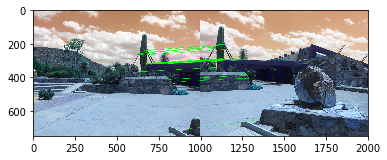

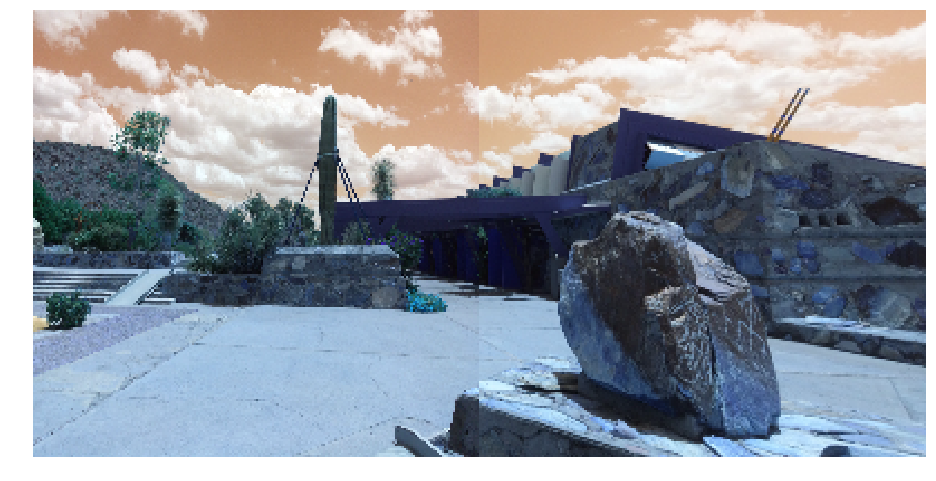

In [20]:
img_list=[]
img_list.append(lol1)
img_list.append(lol2)

M = get_transformation(img_list) 
final_img = stitching(img_list,M)
# final_img = remove_black(final_img)

cv2.imwrite('final_img_1.png', final_img)

final_img = cv2.resize(final_img,(400,200))
fig = plt.figure(figsize=(16,16))
plt.imshow(final_img)
plt.axis('off')
plt.show()

## Stereo Correspondences

- We need to perform Intensity Window-based correlation on a given stereo pair. 
- So let's load the images first.

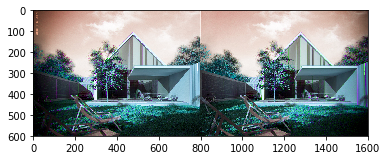

In [123]:
stereo1 = cv2.imread('./images/stereo_images/1.jpg')
plt.imshow(stereo1)

- We need to halve the above image. 
- So we run a loop until the (width/2)th pixel, and cut the image there. 
- For some stupid reason, `image.shape` returns (height x width) and not (width x height)


In [124]:
ht, wt, color= stereo1.shape
print(ht, wt, color)

600 1600 3


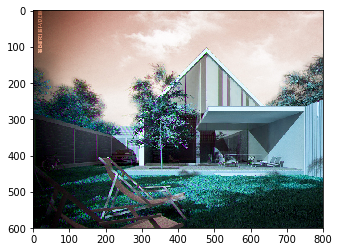

In [125]:
stereo1_left = stereo1[0:ht, 0:wt//2]
stereo1_right = stereo1[0:ht, wt//2:wt]
plt.imshow(stereo1_left)

#### Patch-based Correlation 
- Now we have ourselves a stereo pair of a very pretty house. 
- Let's take a patch in the first image and move it around in the other image and see where we find maximum similarity. 
- We compute the normalised cross-correlation by moving a window around in the images, hence the name - window-based correlation. 

- We define a function `corrs` that computes the normalised cross correlation. 
- Function name is a tribute to one of my favourite bands - The Corrs :D 

In [126]:
def corrs(v1,v2):
    num = v1.T.dot(v2)
    temp1 = np.sqrt(v1.T.dot(v1))
    temp2 = np.sqrt(v2.T.dot(v2))
    denom = temp1 * temp2
    return (num/denom)

- We define a Correlation Matching function, which takes two stereo images as inputs.
- The outer loop - (y1,x1) - loops over all the patches/windows in the first image. 
- The inner loop - (y2,x2) - helps find the corresponding patch of the first image in the second image. It does so by going through all the patches in the second image and returns that with the best normalised cross correlation between the two patches.

In [127]:
def correlation_matching(img1, img2, window_size=128, stride=128, thresh = 0.01):
    h1, w1, c = img1.shape
    h2, w2, c = img2.shape
    
    # Go through all the patches in img1
    best_matches = []
    for y1 in range(0, h1-window_size, stride):
        for x1 in range(0, w1-window_size, stride):
            # make this 100 for stereo3 case
            least_dis = 1
            least_coord = []
            # find the corresponding patch in img2 with best corrs value
            for y2 in range(0, h2-window_size, stride):
                for x2 in range(0, w2-window_size, stride):
                    v1 = img1[y1:y1+window_size, x1:x1+window_size, :].flatten()
                    v2 = img2[y2:y2+window_size, x2:x2+window_size, :].flatten()
                    dis = corrs(v1,v2)
                    if dis < least_dis:
                        least_dis = dis
                        least_coord = [x1,y1,x2,y2,dis]      
            if(least_coord):
                best_matches.append(least_coord)
            else: 
                continue
    return best_matches

- This one is fairly simple; it simply takes the original image (with both the stereo pairs) and plots the matches as line segments joining the corresponding points for easier visualisation.

In [128]:
def draw_matches(img, matches, window_size=128):
    h, w, c = img.shape
    for match in matches:
        pt1 = (match[1] + window_size//2, match[0]+window_size//2)
        pt2 = (match[3] + window_size//2 + w//2, match[2]+ window_size//2)
        line_img = cv2.line(img, pt1, pt2, (0,0,225), 3)
        
    plt.imshow(line_img)

Okay so we've defined all our functions! Now we simply take our stereo images of the house and call the functions.

In [129]:
matches1 = correlation_matching(stereo1_left, stereo1_right)
print("Matches in the form of [x1,y1,x2,y2,distance] \n")
print(matches1)

Matches in the form of [x1,y1,x2,y2,distance] 

[[0, 0, 640, 128, 0.2157], [128, 0, 512, 384, 0.0711], [256, 0, 640, 128, 0.03], [384, 0, 0, 256, 0.2664], [512, 0, 640, 256, 0.05515], [640, 0, 0, 128, 0.0642], [0, 128, 0, 256, 0.01866], [128, 128, 0, 0, 0.1289], [256, 128, 384, 256, 0.02275], [384, 128, 256, 384, 0.03134], [512, 128, 128, 128, 0.00545], [640, 128, 384, 128, 0.034], [0, 256, 0, 128, 0.00639], [128, 256, 640, 384, 0.01281], [256, 256, 0, 384, 0.0], [384, 256, 256, 256, 0.0207], [512, 256, 0, 0, 0.1528], [640, 256, 384, 384, 0.0662], [0, 384, 640, 256, 0.01895], [128, 384, 0, 384, 0.1161], [256, 384, 256, 384, 0.0768], [384, 384, 128, 128, 0.2883], [512, 384, 640, 0, 0.2808], [640, 384, 256, 384, 0.05255]]


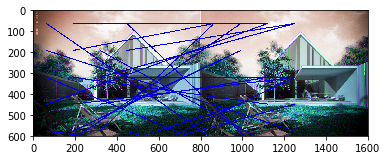

In [130]:
draw_matches(stereo1, matches1)

#### ^ And these are the stereo correspondences. Looks horrible, doesn't it? That's because correlation matching using patches isn't that great.

Similarly, let's do the same thing for the other two stereo pairs

In [131]:
stereo2 = cv2.imread('./images/stereo_images/2.jpg')
ht, wt, color= stereo2.shape
stereo2_left = stereo2[0:ht, 0:wt//2]
stereo2_right = stereo2[0:ht, wt//2:wt]

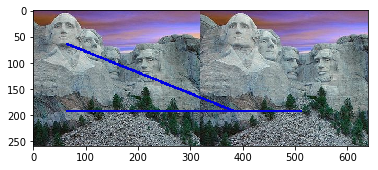

In [132]:
matches2 = correlation_matching(stereo2_left, stereo2_right)
draw_matches(stereo2, matches2)

In [133]:
stereo3 = cv2.imread('./images/stereo_images/3.jpeg')
ht, wt, color = stereo3.shape
stereo3_left = stereo3[0:ht, 0:wt//2]
stereo3_right = stereo3[0:ht, wt//2:wt]

In [134]:
matches3 = correlation_matching(stereo3_left, stereo3_right)
if(matches3):
    draw_matches(stereo3, matches3)
else:
    print("No matches found :(")

No matches found :(


- If we increase the threshold while computing the cross correlation, we end up finding one match, but that's it. 

### Rectifying the stereo images
- We need to first rectify the pairs of images.
- And then with these new images, we perform intensity window-based correlation again. 

In [164]:
def dense_sift_matching(img1,img2,min_match_cnt=500):
    
    # Initiliaze CV2 SIFT
    sift = cv2.xfeatures2d.SIFT_create()

    # Define our keypoints
    h,w,c = img1.shape
    kp=[]
    for i in range(1,h,10):
        for j in range(1,w,10):
            kp.append(cv2.KeyPoint(i, j, 3))
    print("Checking Keypoints",len(kp))
    
    # Taking gray scale images for SIFT
    gray_im1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
    kp1,des1 = sift.compute(gray_im1,kp)

    gray_im2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    kp2,des2 = sift.compute(gray_im2,kp)

    # BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)[0:min_match_cnt]
    print("Found Matches:",len(matches))  
        
    draw_params = dict(matchesMask=None,
                       singlePointColor=None,
                       flags=2)
        
    dis_im = cv2.drawMatches(img1,kp1,img1,kp1,matches,None,**draw_params)
    plt.imshow(dis_im)    
    return kp1,des1,kp2,des2,matches,dis_im

- This function performs stereo rectification. 
- It stores the best matches from SIFT, and we use the `cv2.warpPerspective` function.

In [1]:
def stereo_rectification(img1,img2,sift_params,match_th =0.8):
    kp1,des1,kp2,des2,_,_ = sift_params
    
    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Store best matches
    pts1 = []
    pts2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.RANSAC)

    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    img_size = img1.shape[0:2]
    p,H1,H2=cv2.stereoRectifyUncalibrated(pts1, pts2, F, img_size)
    
    H3= H1.dot(H2)
    img1_corrected = cv2.warpPerspective(img1, H1, img_size)
    img2_corrected = cv2.warpPerspective(img2, H3, img_size)
    return img1_corrected, img2_corrected

In [2]:
stereo1 = cv2.imread('./images/stereo_images/1.jpg')
h,w,c = stereo1.shape
stereo1_left = stereo1[:,0:w//2,:]
stereo1_right = stereo1[:,w//2:w,:]
plt.imshow(stereo1)

NameError: name 'cv2' is not defined

Checking Keypoints 4800
Found Matches: 500


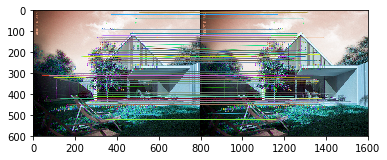

In [227]:
sift_param = dense_sift_matching(stereo1_left, stereo1_right)

In [231]:
rect1_left, rect1_right = stereo_rectification(stereo1_left, stereo1_right, sift_param, match_th =0.8)

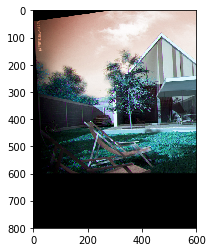

In [232]:
plt.imshow(rect1_left)

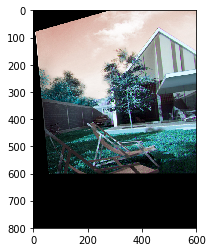

In [233]:
plt.imshow(rect1_right)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


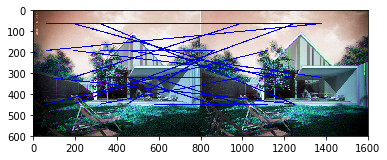

In [234]:
stereo1 = cv2.imread('./images/stereo_images/1.jpg')
matches1 = correlation_matching(rect1_left, rect1_right)
draw_matches(stereo1, matches1)

Checking Keypoints 832
Found Matches: 500


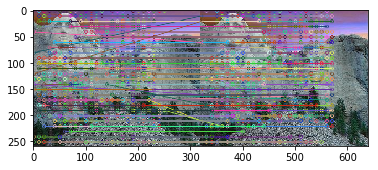

In [235]:
# Case 2
img = cv2.imread('./images/stereo_images/2.jpg')
h,w,c = img.shape
img1 = img[:,0:w//2,:]
img2 = img[:,w//2:w,:]
sift_param = dense_sift_matching(img1,img2)
rect2_left, rect2_right = stereo_rectification(img1,img2,sift_param,match_th =0.8)

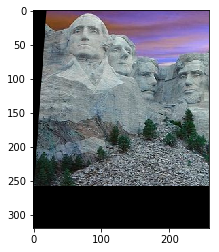

In [236]:
plt.imshow(rect2_left)

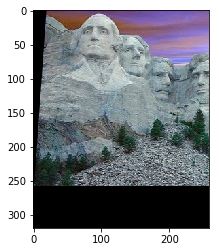

In [237]:
plt.imshow(rect2_right)

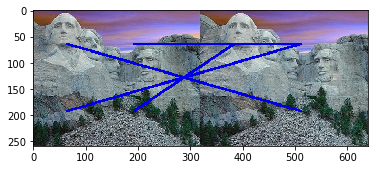

In [238]:
stereo2 = cv2.imread('./images/stereo_images/2.jpg')
matches2 = correlation_matching(rect2_left, rect2_right)
draw_matches(stereo2, matches2)

Checking Keypoints 256
Found Matches: 149


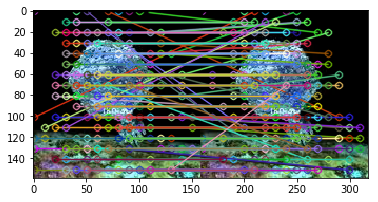

In [245]:
img = cv2.imread('./images/stereo_images/3.jpeg')
h,w,c = img.shape
img1 = img[:,0:w//2,:]
img2 = img[:,w//2:w,:]
sift_param = dense_sift_matching(img1,img2)
rect3_left, rect3_right = stereo_rectification(img1,img2,sift_param,match_th =0.8)

### Greedy Matching and DP for Stereo Correspondences

- This matching works by finding the longest common subsequence between two lines. 
- Here the lines are epipolar lines of the 2 stereo images
- We compute the longest subsequence on the epipolar lines of the 2 stereo images. 
- Before computing the epipolar lines, we warp the images images such that the epipolar lines are horizontal which makes it easier and faster to run LCS

In [241]:
stereo1 = cv2.imread('./images/stereo_images/1.jpg')
ht, wt, color= stereo1.shape
stereo1_left = stereo1[0:ht, 0:wt//2]
stereo1_right = stereo1[0:ht, wt//2:wt]

- img1 is the image on which we draw the epilines for the points in img2
- lines refer to the corresponding epipolar lines

In [232]:
def drawlines(img1,img2,lines,pts1,pts2):
    r,c,_ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

- Computes the LCS between two epipolar lines. 
- `dp[i,j] = max(C(i - 1, j - 1)  + dp[i-1, j-1], dp[i-1,j]. dp[i,j-1])`
- This is if we were to do it in top-down fashion! 



In [233]:
def longest_common_subsequence(line1, line2):
    dp = np.zeros((line1.shape[0]+1,line2.shape[0]+1))
    
    for i,x in enumerate(line1):
        for j,y in enumerate(line2):
            if(i==0 or j==0):
                continue
            elif (line1[i-1] == line1[j-1]): 
                dp[i,j] = 1 + dp[i-1][j-1]
            else:
                dp[i,j] = max(dp[i-1,j], dp[i,j-1])

    i = line1.shape[0], j = line2.shape[0]; 
    lcs = np.zeros(line1.shape[0])
    index = line1.shape[0]
    while (i > 0 and j > 0) : 
        if (line1[i-1] == line2[j-1]): 
            lcs[index-1] = line1[i-1]
            i-=1
            j-=1
            index-=1 
      
        elif (dp[i-1,j] > dp[i,j-1]): 
            i-=1 
        else:
            j-=1
    return lcs

In [234]:
def plot_epipolar_lines(img1,img2,sift_params,match_th =0.8):
    kp1,des1,kp2,des2,_,_ = sift_params
    
    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
#     Store best matches
    pts1 = []
    pts2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.RANSAC)

    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
 
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img3,img4 = drawlines(img1,img2,lines1,pts1,pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img5,img6 = drawlines(img2,img1,lines2,pts2,pts1)
    
    return lines1, lines2, img3, img4, img5, img6

Checking Keypoints 4800
Found Matches: 500


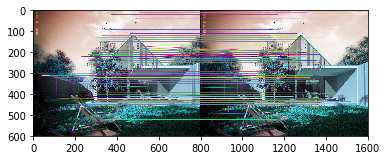

In [235]:
sift_param = dense_sift_matching(stereo1_left, stereo1_right)

In [243]:
l1, l2, i3, i4, i5, i6 = plot_epipolar_lines(stereo1_left, stereo1_right, sift_param)

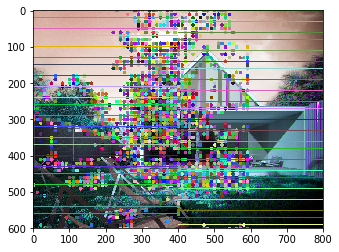

In [244]:
plt.imshow(i4)

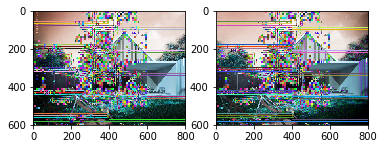

In [245]:
plt.subplot(121)
plt.imshow(i3)
plt.subplot(122)
plt.imshow(i4)